---
# 1. 필요 라이브러리 불러오기
---

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [ ]:
import numpy
import tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import tensorflow_addons as tfa

print(numpy.__version__)
print(tensorflow.__version__)

1.21.6
2.8.2


----
# 2. 데이터 로드
----

In [ ]:
data_path_train = '/content/drive/MyDrive/aiffel/EXP16/data/cityscapes/train/'
data_path_val = '/content/drive/MyDrive/aiffel/EXP16/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(data_path_train)))
print("number of train examples :", len(os.listdir(data_path_val)))

number of train examples : 1000
number of train examples : 5


- train 데이터 시각적으로 확인 

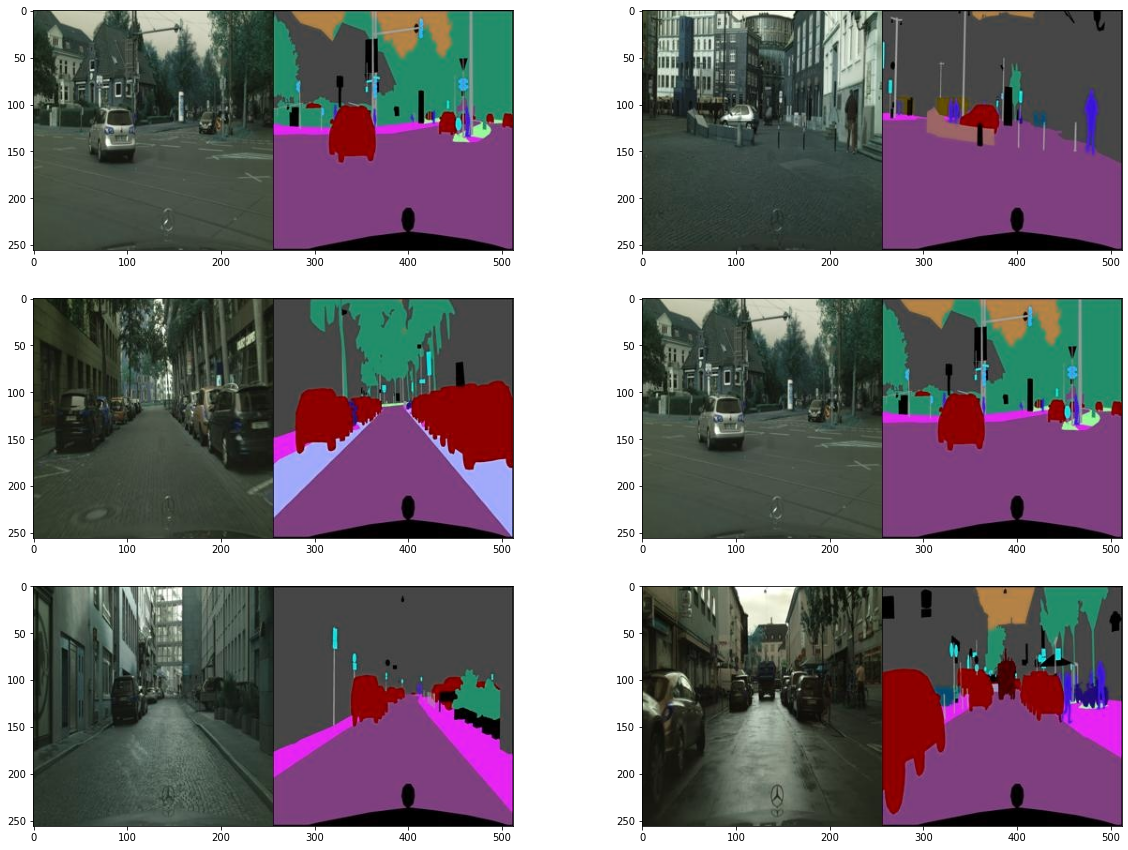

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path_train + os.listdir(data_path_train)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- val 데이터 시각적으로 확인 

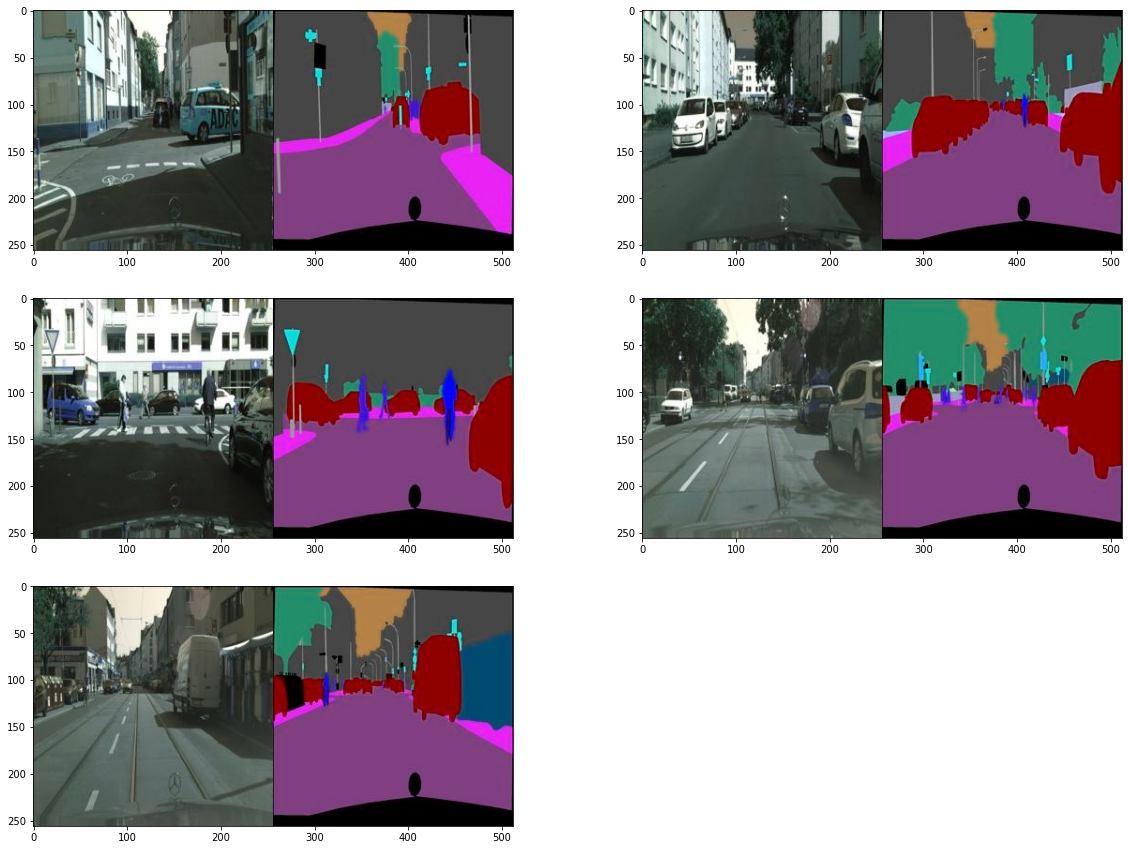

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1,6):
    f = data_path_val + os.listdir(data_path_val)[i-1]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이미지 크기 확인

In [ ]:
f = data_path_train + os.listdir(data_path_train)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 모델 학습을 위해 (256,256,3)의 이미지 2개로 분리

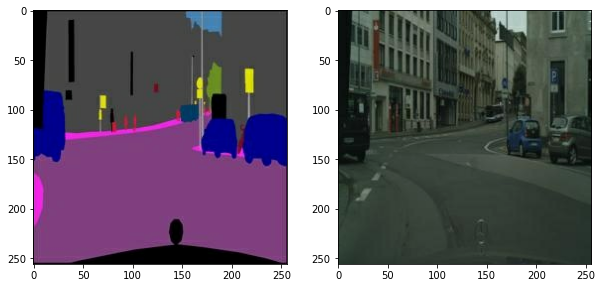

In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path_train + os.listdir(data_path_train)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

---
# 3. 다양한 augmentation 적용
---

In [ ]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결 3+3 = 6채널
    
    _pad = tf.constant([[30,30],[30,30],[0,0]]) # 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT") # Refection padding
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # constant padding

    out = image.random_crop(padded, size=[256, 256, 6]) # (256,256,6) 크기를 가진 이미지를 임의로 잘라내기. 
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집기
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집기
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 50% 확률로 회전
    
    return out[...,:3], out[...,3:]   

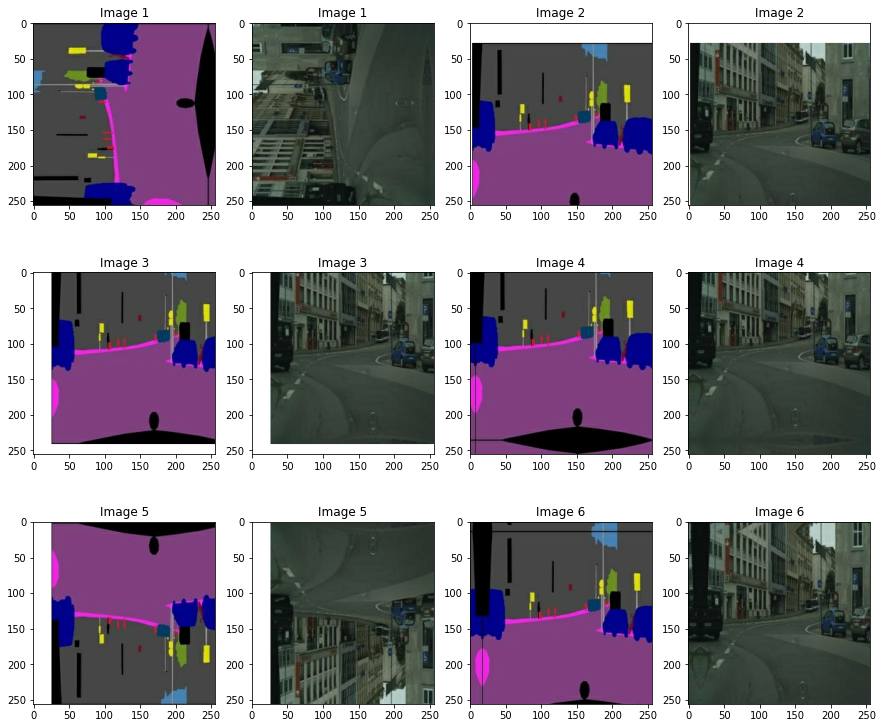

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

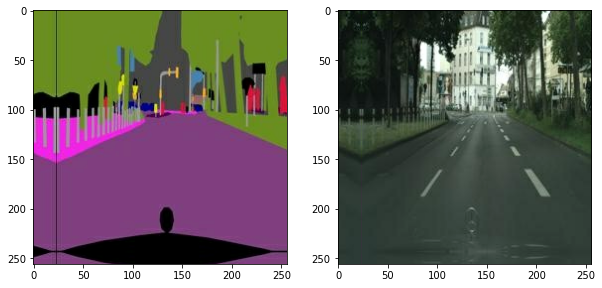

In [ ]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path_train + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

----
# 4. 모델 구성하기
----

---
### 4-1. Generator 구성하기
---

---
##### 4-1-1 Encoder
----

- "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록
- Convolution 레이어에서 필터의 크기(=4) / stride(=2) / LeakyReLU 활성화의 slope coefficient(=0.2)

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False) # 필터 크기 = 4 / stride = 2 / padding = same
        self.batchnorm = layers.BatchNormalization() # 배치정규화
        self.lrelu= layers.LeakyReLU(0.2) # 활성화함수 

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)): # summary 함수
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Encoder().get_summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_40 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_41 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_42 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_43 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                        

---
##### 4-1-2 Decoder
----

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
Decoder().get_summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block_35 (DecodeBloc  (None, 2, 2, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_36 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_37 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_38 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                        

---
##### 4-1-3 U-net generator
----

- Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
- 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과
- features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        # why? features[:-1]
        # Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, 
        # Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문.            

        for block, feat in zip(self.decode_blocks, features[::-1]):
          # why? feature[::-1]
          # Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, 
          # Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룸
          # features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결.

            x = block(x)
            x = layers.Concatenate()([x, feat])
            # layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결 (8,32,32,100) + (8,32,32,200) = (32,32,300)
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_48 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_49 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_48[0][0]']        
                                                                                            

---
### 4-2. Discriminator 구성하기
---

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:                                               # valid = 패딩을 추가하지 않는 형태
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

-  (width, height) 크기가 1씩 감소하는 방법

In [ ]:
# inputs = Input((128,128,32))
# out = layers.ZeroPadding2D()(inputs) # 제로패딩으로 (130,130,32)
# out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out) # 패딩x / filter = 4 / stride = 1 => 3씩 감소
#                                                             # (127,127,32)
# out = layers.BatchNormalization()(out)
# out = layers.LeakyReLU(0.2)(out)

# Model(inputs, out).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable p

- 왜 (30,30)으로 크기를 맞춰야 하는가?
  - Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞춰줘야 한다.

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
                                                  # use_bn=True는 배치노말 사용 / act=True는 활성화함수(리키렐루) 사용 
                                                  # Custom_pad = True는 valid패딩 
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_39 (Concatenate)   (None, 256, 256, 6)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

---
### 4-3. 손실함수 구성하기
---

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc): # fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
    l1_loss = mae(real_output, fake_output)  #  L1 손실을 계산하기 위해 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc) # 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용
    return gene_loss, l1_loss 

def get_disc_loss(fake_disc, real_disc): # 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
    # Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교

---
### 4-4. Optimizer 구성하기
---

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

---
# 5. 모델 학습하기
---

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 300

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch,colored)
                
    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())

    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

(-0.5, 255.5, 255.5, -0.5)

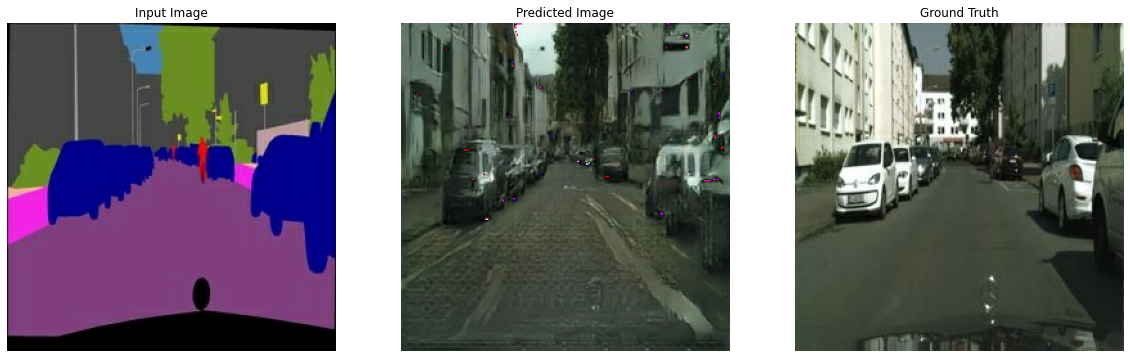

In [ ]:
test_ind = 1

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

Text(0.5, 0, 'Epoch')

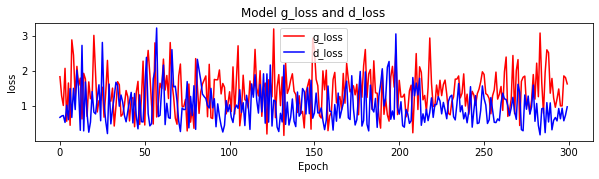

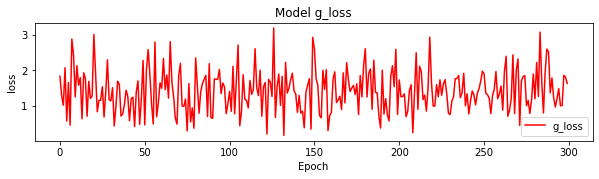

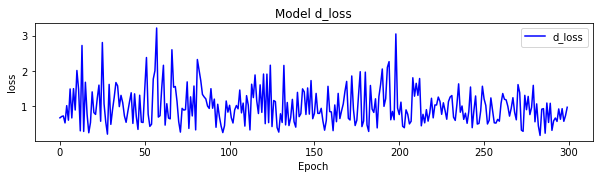

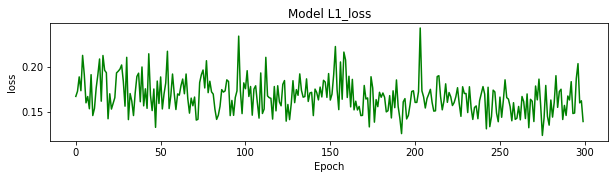

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['g_loss'], 'red')
plt.plot(history['d_loss'], 'blue')
plt.title('Model g_loss and d_loss')
plt.ylabel('loss')
plt.legend(['g_loss','d_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 2)
plt.plot(history['g_loss'], 'red')
plt.title('Model g_loss')
plt.ylabel('loss')
plt.legend(['g_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(history['d_loss'], 'blue')
plt.legend(['d_loss'],loc='best')
plt.title('Model d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 4)
plt.plot(history['l1_loss'], 'g')
plt.title('Model L1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

----
# 6. 모델 개선해보기
---

---
### 6-1 optimizier 변경
---

- Adam -> Radam
- 생성자 learning_rate = 2e-4 -> 5e-5
- 판별자 learning_rate = 2e-4 -> 1e-5

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
gene_opt = tfa.optimizers.RectifiedAdam(lr=5e-5, warmup_proportion=0.01, min_lr=1e-4)
disc_opt = tfa.optimizers.RectifiedAdam(lr=1e-5, warmup_proportion=0.01, min_lr=5e-5)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 300

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch,colored)
                
    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())

    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

(-0.5, 255.5, 255.5, -0.5)

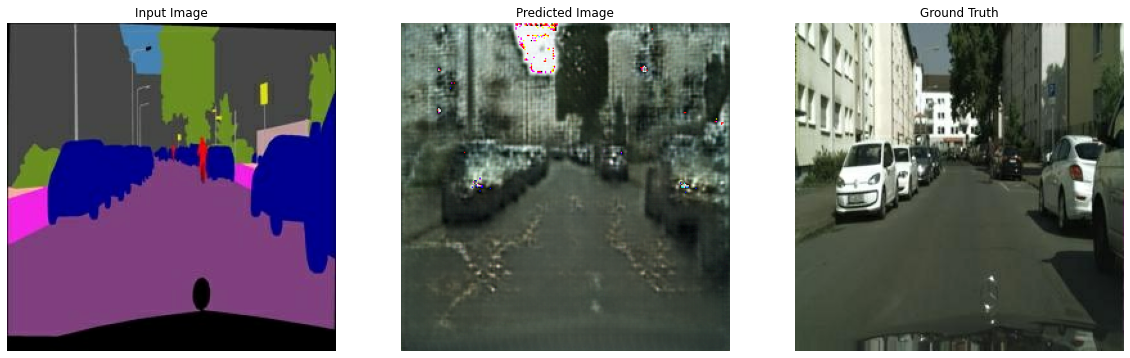

In [ ]:
test_ind = 1

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

이미지 자체가 어느정도 형성은 되었으나, 형태를 구분하기가 모호하고 노이즈가 많이 끼어있는 것을 볼 수 있다.

Text(0.5, 0, 'Epoch')

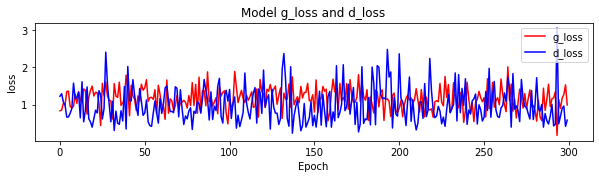

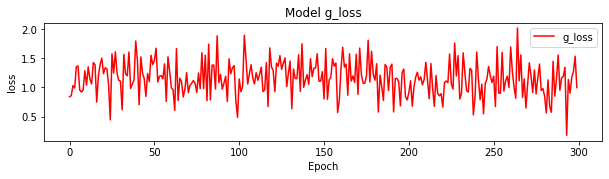

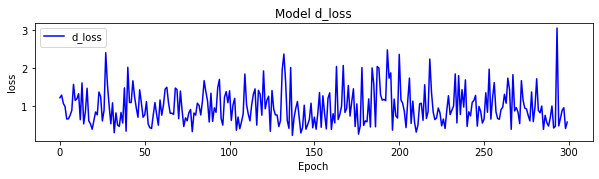

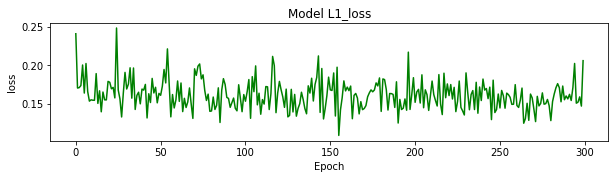

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['g_loss'], 'red')
plt.plot(history['d_loss'], 'blue')
plt.title('Model g_loss and d_loss')
plt.ylabel('loss')
plt.legend(['g_loss','d_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 2)
plt.plot(history['g_loss'], 'red')
plt.title('Model g_loss')
plt.ylabel('loss')
plt.legend(['g_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(history['d_loss'], 'blue')
plt.legend(['d_loss'],loc='best')
plt.title('Model d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 4)
plt.plot(history['l1_loss'], 'g')
plt.title('Model L1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

시각적으로 보았을 때, 바꾸지 않았을 때보다 오히려 더 노이즈가 끼어있는( 덜 생성된) 느낌을 받는다.

---
### 6-2 optimizer 변경 및 epoch 증가
---

- optimizer를 Radm -> Adam으로 변경
- learning_rate값은 고정하고 epoch을 500회로 증가

In [ ]:
gene_opt = optimizers.Adam(lr=5e-5)
disc_opt = optimizers.Adam(lr=1e-5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 500

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch,colored)
                
    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())

    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

(-0.5, 255.5, 255.5, -0.5)

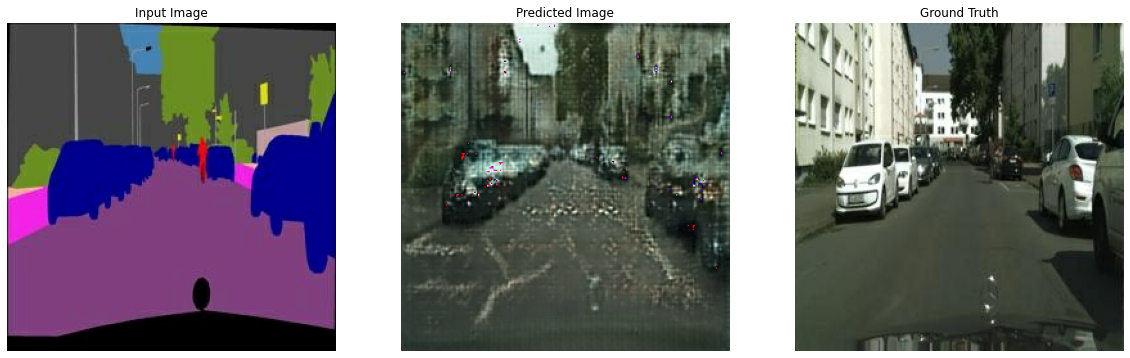

In [ ]:
test_ind = 1

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

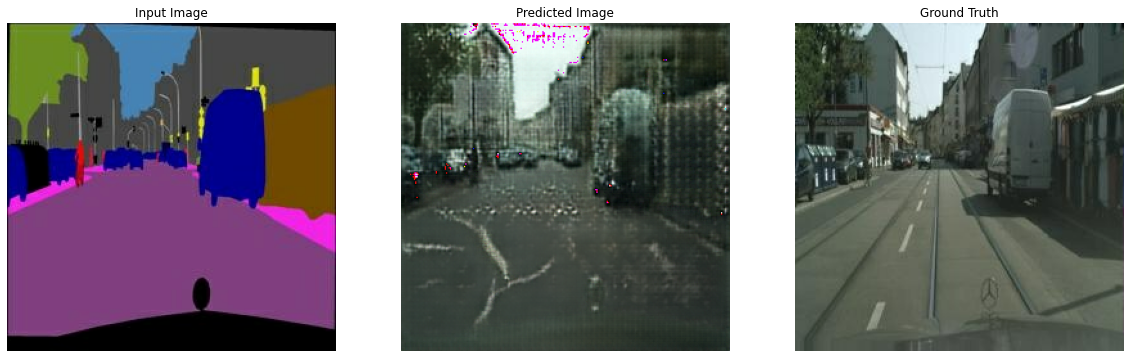

In [ ]:
test_ind = 4

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

색깔점도 많고, 이미지 전체가 흐릿한 모습을 보이고 있다.

Text(0.5, 0, 'Epoch')

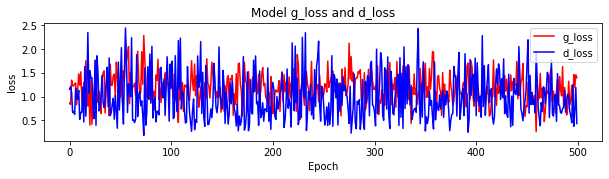

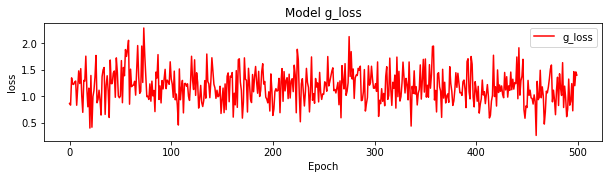

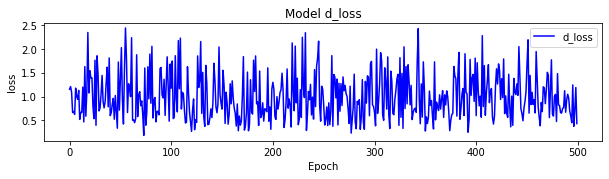

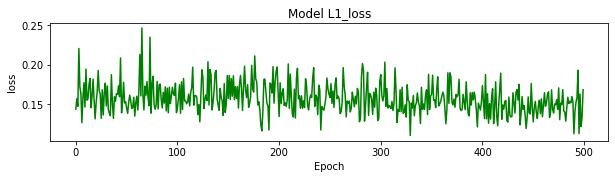

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['g_loss'], 'red')
plt.plot(history['d_loss'], 'blue')
plt.title('Model g_loss and d_loss')
plt.ylabel('loss')
plt.legend(['g_loss','d_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 2)
plt.plot(history['g_loss'], 'red')
plt.title('Model g_loss')
plt.ylabel('loss')
plt.legend(['g_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(history['d_loss'], 'blue')
plt.legend(['d_loss'],loc='best')
plt.title('Model d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 4)
plt.plot(history['l1_loss'], 'g')
plt.title('Model L1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

6-1번 파트의 이미지 보다는 조금 더 선명해 졌으나, 5번 파트의 이미지 보다 개선이 되었다고는 말하기 어려운 것 같다.  
현재 까지의 결론은 5번 파트의 optimizer = Adam / learning_Rate = 2e-4가 가장 최적이며,  
해당 값을 토대로 epoch을 늘리면 더 좋은 이미지가 나올 것이라 예상 된다.

---
### 6-3 Layer 늘려보기
----
- 기존 생성자는 encoder 8층 decoder 7층으로 이루어져있다.
- 생성자의 encoder를 10층 decoder를 9층으로 늘려서 테스트를 진행해 보겠다.
- decoder의 활성화 함수 Relu를 leakyRelu로 변경
- 5번 파트의 optimizer를 그대로 사용
- epoch = 500번 

In [ ]:
class UnetGenerator(Model):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        
# =============================== 인코더 부분 ===============================
        self.conv1 = layers.Conv2D(32,(4,4), strides=(2,2), padding='same')
        self.batch1 = layers.BatchNormalization()
        self.lrelu1 = layers.LeakyReLU(0.2)
        
        self.conv2 = layers.Conv2D(32,(4,4), strides=(1,1), padding='same')
        self.batch2 = layers.BatchNormalization()
        self.lrelu2 = layers.LeakyReLU(0.2)
                
        self.conv3 = layers.Conv2D(64,(4,4), strides=(2,2), padding='same')
        self.batch3 = layers.BatchNormalization()
        self.lrelu3 = layers.LeakyReLU(0.2)
        
        self.conv4 = layers.Conv2D(64,(4,4), strides=(1,1), padding='same')
        self.batch4 = layers.BatchNormalization()
        self.lrelu4 = layers.LeakyReLU(0.2)
        
        self.conv5 = layers.Conv2D(128,(4,4), strides=(2,2), padding='same')
        self.batch5 = layers.BatchNormalization()
        self.lrelu5 = layers.LeakyReLU(0.2)
        
        self.conv6 = layers.Conv2D(128,(4,4), strides=(2,2), padding='same')
        self.batch6 = layers.BatchNormalization()
        self.lrelu6 = layers.LeakyReLU(0.2)
        
        self.conv7 = layers.Conv2D(256,(4,4), strides=(2,2), padding='same')
        self.batch7 = layers.BatchNormalization()
        self.lrelu7 = layers.LeakyReLU(0.2)
        
        self.conv8 = layers.Conv2D(256,(4,4), strides=(2,2), padding='same')
        self.batch8 = layers.BatchNormalization()
        self.lrelu8 = layers.LeakyReLU(0.2)
        
        self.conv9 = layers.Conv2D(512,(4,4), strides=(2,2), padding='same')
        self.batch9 = layers.BatchNormalization()
        self.lrelu9 = layers.LeakyReLU(0.2)
        
        self.conv10 = layers.Conv2D(512,(4,4), strides=(2,2), padding='same')
        self.batch10 = layers.BatchNormalization()
        self.lrelu10 = layers.LeakyReLU(0.2)
    
# =============================== 디코더 부분 ===============================
        self.d_conv1 = layers.Conv2DTranspose(512,(4,4), strides=(2,2), padding='same')
        self.d_batch1 = layers.BatchNormalization()
        self.d_lrelu1 = layers.LeakyReLU(0.2)
        
        self.d_conv2 = layers.Conv2DTranspose(512,(4,4), strides=(2,2), padding='same')
        self.d_batch2 = layers.BatchNormalization()
        self.d_lrelu2 = layers.LeakyReLU(0.2)
                
        self.d_conv3 = layers.Conv2DTranspose(256,(4,4), strides=(2,2), padding='same')
        self.d_batch3 = layers.BatchNormalization()
        self.d_lrelu3 = layers.LeakyReLU(0.2)
        
        self.d_conv4 = layers.Conv2DTranspose(256,(4,4), strides=(2,2), padding='same')
        self.d_batch4 = layers.BatchNormalization()
        self.d_lrelu4 = layers.LeakyReLU(0.2)
        
        self.d_conv5 = layers.Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')
        self.d_batch5 = layers.BatchNormalization()
        self.d_lrelu5 = layers.LeakyReLU(0.2)
        
        self.d_conv6 = layers.Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')
        self.d_batch6 = layers.BatchNormalization()
        self.d_lrelu6 = layers.LeakyReLU(0.2)
        
        self.d_conv7 = layers.Conv2DTranspose(64,(4,4), strides=(1,1), padding='same')
        self.d_batch7 = layers.BatchNormalization()
        self.d_lrelu7 = layers.LeakyReLU(0.2)
        
        self.d_conv8 = layers.Conv2DTranspose(64,(4,4), strides=(2,2), padding='same')
        self.d_batch8 = layers.BatchNormalization()
        self.d_lrelu8 = layers.LeakyReLU(0.2)
        
        self.d_conv9 = layers.Conv2DTranspose(32,(4,4), strides=(1,1), padding='same')
        self.d_batch9 = layers.BatchNormalization()
        self.d_lrelu9 = layers.LeakyReLU(0.2)
        
        self.d_conv10 = layers.Conv2DTranspose(3,(4,4), strides=(2,2), padding='same')

    def call(self, x):
        
# =============================== 인코더 부분 ===============================
        p1 = self.conv1(x)
        p1 = self.batch1(p1)
        p2 = self.lrelu1(p1)
        
        p2 = self.conv2(p2)
        p2 = self.batch2(p2)
        p3 = self.lrelu2(p2)
        
        p3 = self.conv3(p3)
        p3 = self.batch3(p3)
        p4 = self.lrelu3(p3)
        
        p4 = self.conv4(p4)
        p4 = self.batch4(p4)
        p5 = self.lrelu4(p4)
        
        p5 = self.conv5(p5)
        p5 = self.batch5(p5)
        p6 = self.lrelu5(p5)
        
        p6 = self.conv6(p6)
        p6 = self.batch6(p6)
        p7 = self.lrelu6(p6)
        
        p7 = self.conv7(p7)
        p7 = self.batch7(p7)
        p8 = self.lrelu7(p7)
        
        p8 = self.conv8(p8)
        p8 = self.batch8(p8)
        p9 = self.lrelu8(p8)
        
        p9 = self.conv9(p9)
        p9 = self.batch9(p9)
        p10 = self.lrelu9(p9)
        
        p10 = self.conv10(p10)
        p10 = self.batch10(p10)
        p11 = self.lrelu10(p10)

# =============================== 디코더 부분 ===============================

        d1 = layers.Concatenate()([p10,p11])
        d1 = self.d_conv1(d1)
        d1 = self.d_batch1(d1)
        d2 = self.d_lrelu1(d1)
        
        d2 = layers.Concatenate()([d2,p9])
        d2 = self.d_conv2(d2)
        d2 = self.d_batch2(d2)
        d3 = self.d_lrelu2(d2)

        d3 = layers.Concatenate()([d3,p8])        
        d3 = self.d_conv3(d3)
        d3 = self.d_batch3(d3)
        d4 = self.d_lrelu3(d3)
        
        d4 = layers.Concatenate()([d4,p7])         
        d4 = self.d_conv4(d4)
        d4 = self.d_batch4(d4)
        d5 = self.d_lrelu4(d4)

        d5 = layers.Concatenate()([d5,p6])         
        d5 = self.d_conv5(d5)
        d5 = self.d_batch5(d5)
        d6 = self.d_lrelu5(d5)

        d6 = layers.Concatenate()([d6,p5])         
        d6 = self.d_conv6(d6)
        d6 = self.d_batch6(d6)
        d7 = self.d_lrelu6(d6)
        
        d7 = layers.Concatenate()([d7,p4])         
        d7 = self.d_conv7(d7)
        d7 = self.d_batch7(d7)
        d8 = self.d_lrelu7(d7)
        
        d8 = layers.Concatenate()([d8,p3])         
        d8 = self.d_conv8(d8)
        d8 = self.d_batch8(d8)
        d9 = self.d_lrelu8(d8)
        
        d9 = layers.Concatenate()([d9,p2]) 
        d9 = self.d_conv9(d9)
        d9 = self.d_batch9(d9)
        x = self.d_lrelu9(d9)
        
        x = layers.Concatenate()([x,p1])
        x = self.d_conv10(x) 

        return x
        
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UnetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:                                               # valid = 패딩을 추가하지 않는 형태
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
                                                  # use_bn=True는 배치노말 사용 / act=True는 활성화함수(리키렐루) 사용 
                                                  # Custom_pad = True는 valid패딩 
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_10[0][0]       

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc): # fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
    l1_loss = mae(real_output, fake_output)  #  L1 손실을 계산하기 위해 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc) # 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용
    return gene_loss, l1_loss 

def get_disc_loss(fake_disc, real_disc): # 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
    # Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 500

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UnetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch,colored)
                
    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())
    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

(-0.5, 255.5, 255.5, -0.5)

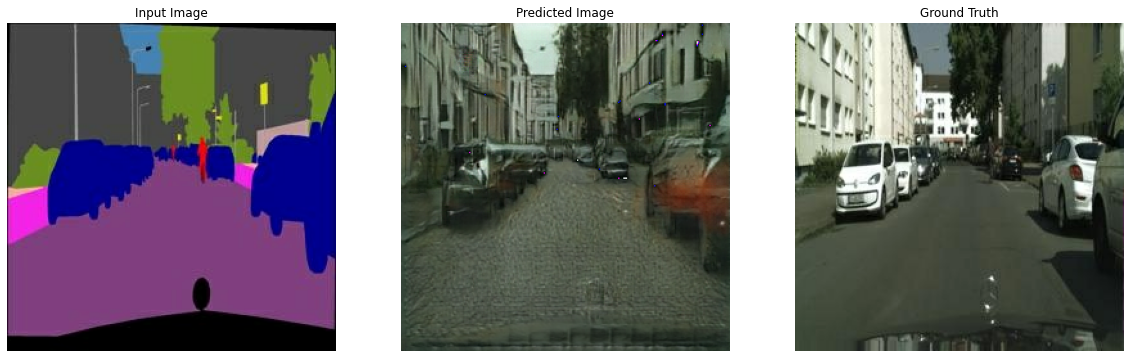

In [ ]:
test_ind = 3

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

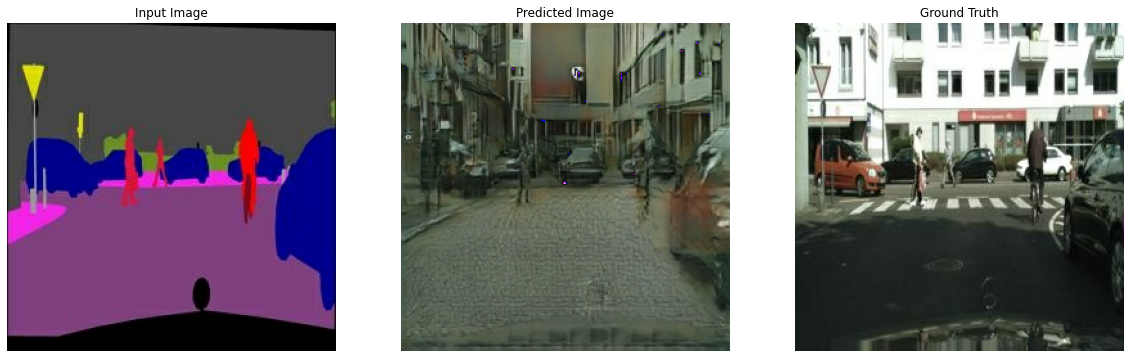

In [ ]:
test_ind = 1

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

결과적으로 기존의 이미지와는 조금은 다른 이미지 들이 형성 되었다.  
특히 바닥은 모두 벽돌처럼 보이는 바닥으로 변경되었으며,   
차량과 사람의 형태는 노이즈가 많이 있다.  
층을 늘려 소요 시간도 더 걸렸지만 만족스러운 결과물을 얻지는 못 한 것 같다.

Text(0.5, 0, 'Epoch')

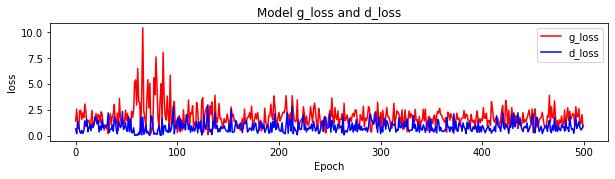

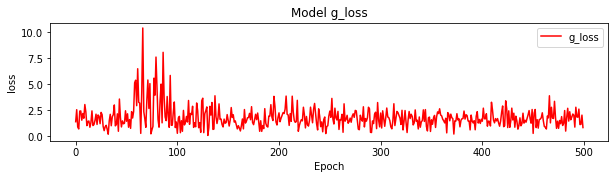

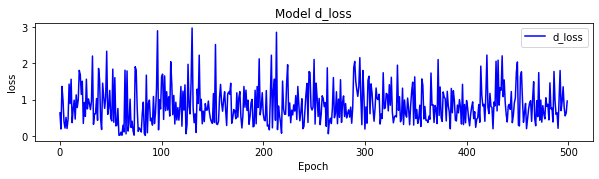

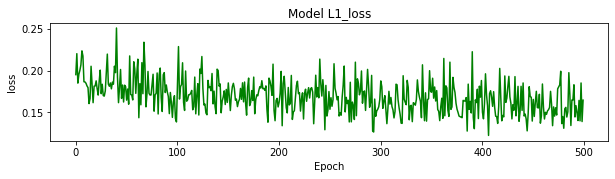

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['g_loss'], 'red')
plt.plot(history['d_loss'], 'blue')
plt.title('Model g_loss and d_loss')
plt.ylabel('loss')
plt.legend(['g_loss','d_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 2)
plt.plot(history['g_loss'], 'red')
plt.title('Model g_loss')
plt.ylabel('loss')
plt.legend(['g_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(history['d_loss'], 'blue')
plt.legend(['d_loss'],loc='best')
plt.title('Model d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 4)
plt.plot(history['l1_loss'], 'g')
plt.title('Model L1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

----
### 6-4 Layer 줄여보기
----

- 5번 파트의 optimizer값을 그대로 사용
- 판별자가 모델의 성능을 좌우할 것이라는 가정하에 판별자의 경우 더 많은 정보를 볼 수 있게끔 늘리고,  
  상대적으로 생성자의 Layer층을 가볍게 만들어 보겠다.
- 이전 값 보다 생성자(U-net)의 encoder / decoder Layer층을 1단씩계 줄이고
- 판별자의 Layer층을 1단계 깊게 쌓아보겠다.
- 더 좋은 결과물을 도출하기 위해 epoch은 500번으로 설정

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512]
        decode_filters = [512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        # why? features[:-1]
        # Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, 
        # Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문.            

        for block, feat in zip(self.decode_blocks, features[::-1]):
          # why? feature[::-1]
          # Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, 
          # Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룸
          # features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결.

            x = block(x)
            x = layers.Concatenate()([x, feat])
            # layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결 (8,32,32,100) + (8,32,32,200) = (32,32,300)
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_9 (EncodeBlock)   (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_10 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_9[0][0]']         
                                                                                              

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:                                               # valid = 패딩을 추가하지 않는 형태
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=32, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3= DiscBlock(n_filters=64, stride=1, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block7 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
                                                  # use_bn=True는 배치노말 사용 / act=True는 활성화함수(리키렐루) 사용 
                                                  # Custom_pad = True는 valid패딩 
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 500

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch,colored)
                
    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())
    if epoch % 10 == 0 : 
      print(f"EPOCH[{epoch}] \
              \nGenerator_loss:{g_loss.numpy():.4f} \
              \nL1_loss:{l1_loss.numpy():.4f} \
              \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[10]               
Generator_loss:1.9759               
L1_loss:0.1833               
Discriminator_loss:0.8531

EPOCH[20]               
Generator_loss:0.6846               
L1_loss:0.2009               
Discriminator_loss:0.7951

EPOCH[30]               
Generator_loss:1.4888               
L1_loss:0.1659               
Discriminator_loss:0.4861

EPOCH[40]               
Generator_loss:0.8572               
L1_loss:0.1913               
Discriminator_loss:0.8647

EPOCH[50]               
Generator_loss:1.9936               
L1_loss:0.1427               
Discriminator_loss:0.6761

EPOCH[60]               
Generator_loss:0.7813               
L1_loss:0.1423               
Discriminator_loss:0.8899

EPOCH[70]               
Generator_loss:1.7526               
L1_loss:0.2070               
Discriminator_loss:0.2597

EPOCH[80]               
Generator_loss:0.2638               
L1_loss:0.1746               
Discriminator_loss:1.7135

EPOCH[90]               
Generator_loss:0.8722  

(-0.5, 255.5, 255.5, -0.5)

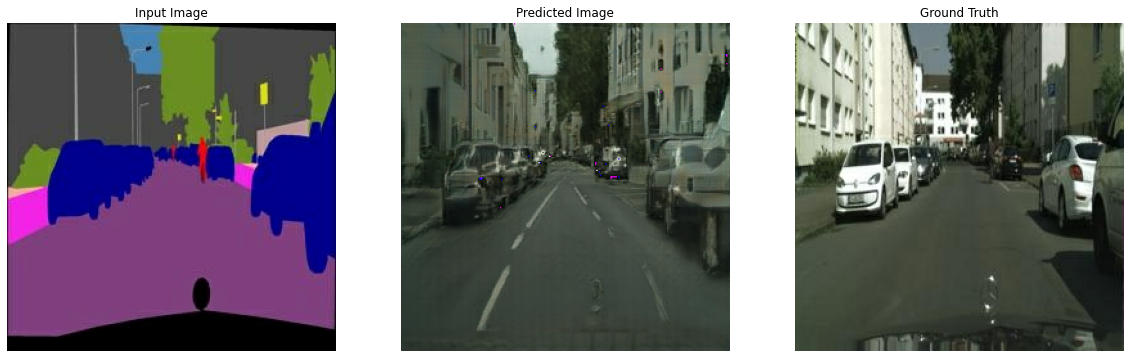

In [ ]:
test_ind = 1

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

5번 파트의 이미지보다 색깔점의 갯수도 더 적고 매끄러운 이미지가 나왔다.  
확실히 이미지를 좌지우지하는 것은 판별자가 더 영향이 있는 것 같다.

(-0.5, 255.5, 255.5, -0.5)

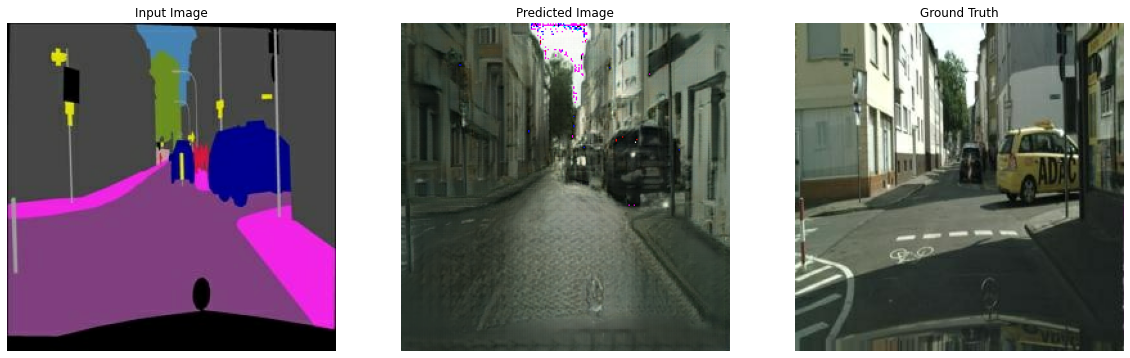

In [ ]:
test_ind = 0

f = data_path_val + os.listdir(data_path_val)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

우측 원본 이미지 와는 다르지만, 건물의 디자인도 고딕풍의 디자인이 되었고 하단의 차도도 벽돌 처럼 잘 이미지가 형성 되었다.   
다만, 우측 택시가 들어가는 도로의 이미지가 건물이 되면서 차량 이미지가 다소 이상한 모습을 보이고 있다.

Text(0.5, 0, 'Epoch')

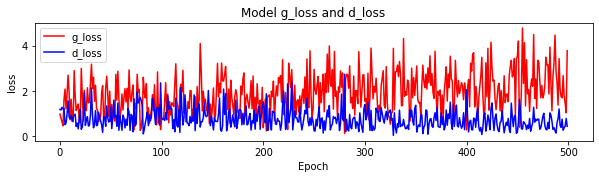

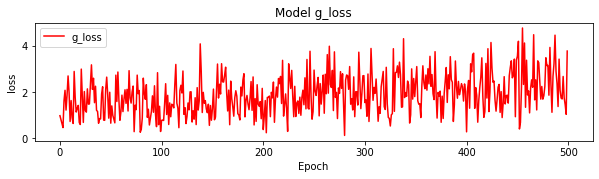

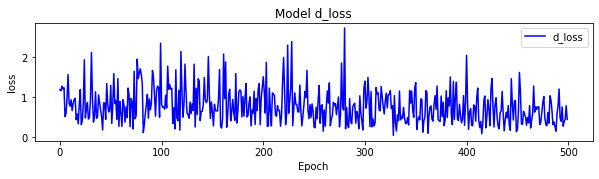

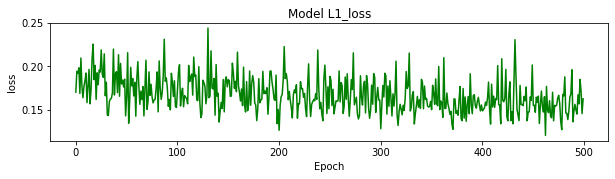

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['g_loss'], 'red')
plt.plot(history['d_loss'], 'blue')
plt.title('Model g_loss and d_loss')
plt.ylabel('loss')
plt.legend(['g_loss','d_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 2)
plt.plot(history['g_loss'], 'red')
plt.title('Model g_loss')
plt.ylabel('loss')
plt.legend(['g_loss'],loc='best')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(history['d_loss'], 'blue')
plt.legend(['d_loss'],loc='best')
plt.title('Model d_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 4)
plt.plot(history['l1_loss'], 'g')
plt.title('Model L1_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')

----
# 7. 회고
----
- 깃에서 모델 학습의 결과물이 모두 나오기 때문에 마지막 모델을 제외하고는 모델 학습의 출력 값을 지웠다. <br><br>
- optimizer도 바꿔보고 레이어의 층도 바꿔보는 등 최적의 이미지를 뽑아내기 위해 여러번의 시도를 거쳤다.<br><br>
- 합리적인 결과값을 보기 위해 epoch의 수를 백단위로 설정하다 보니 다소 시간이 많이 걸렸으며,  
결과값을 비교할 때, 수치적인 요소를 보는 것이 아닌 시각적인 이미지의 결과로 판단을 하다보니 어떤 점이 더 좋을지 헷갈리는 부분이 다분했다.<br><br>
- 시각적인 부분을 기준으로 했을 때, 생성자의 Layer를 줄이고 판별자에 Layer를 늘리는 것이 가장 좋은 값을 뽑아냈다.<br><br>
- 해당 값을 바탕으로 보면 GAN의 성능을 좌우하는 값은 판별자가 더 큰 영향을 미치는 것 같다.<br><br>
- U-net 부분에서 주어진 코드는 input값인 256을 기준으로 8개 층을 쌓았다. stride를 2를 고정으로 주기 떄문에 추가적으로 layer를 쌓으면 마지막 부분에 (1,1,512) (1,1,512) 가 반복되는 형태를 보였다.<br><br>
- 해당 문제를 해결하기 위해(stride값을 변경하기 위해) 반복문으로 Layer층을 쌓는 것이 아닌 일일이 Layer층을 쌓았다. <br><br>
- U-net에 대한 이해가 부족해 Layer를 쌓는 과정에서 많은 시간 소요와 어려움을 느꼈다.